In [1]:
from IPython import display
import pandas as pd
import random
import time
import math
import sys
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

In [2]:
from matplotlib import pyplot as plt

# 定义绘图相关函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.""" 
    # display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(7, 5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, 
         xscale='linear', yscale='linear',fmts=('-', 'm--', 'g-.', 'r:'), figsize=(7, 5), axes=None
    ):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if X (ndarray or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    plt.show()
    
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

def sgd(params, lr, batch_size):  #@save
    for param in params:
        param[:] = param - lr * param.grad / batch_size

#  03. Linear Neural Networks
Before we get into the details of deep neural networks, we need to cover the basics of neural network training. In this chapter, we will cover the entire training process, including defining simple neural network architectures, handling data, specifying a loss function, and training the model. In order to make things easier to grasp, we begin with the simplest concepts. Fortunately, classic statistical learning techniques such as linear and logistic regression can be cast as shallow neural networks. Starting from these classic algorithms, we will introduce you to the basics, providing the basis for more complex techniques such as softmax regression (introduced at the end of this chapter) and multilayer perceptrons (introduced in the next chapter).

## 3.5 The Image Classification Dataset
In `Section 18.9`, we trained a naive Bayes classifier, using the `MNIST` dataset introduced in 1998 (LeCun et al., 1998). While `MNIST` had a good run as a benchmark dataset, even simple models by todayʼs standards achieve classification accuracy over $95\%$ making it unsuitable for distinguishing between stronger models and weaker ones. Today, `MNIST` serves as more of sanity checks than as a benchmark. To up the ante just a bit, we will focus our discussion in the coming sections on the qualitatively similar, but comparatively complex `Fashion-MNIST` dataset (Xiao et al., 2017), which was released in 2017.

### 3.5.1 Getting the Dataset
Just as with `MNIST`, `Gluon` makes it easy to download and load the `Fashion-MNIST` dataset into memory via the `FashionMNIST` class contained in `gluon.data.vision`. We briefly work through the mechanics of loading and exploring the dataset below. Please refer to `Section 18.9` for more details on loading data.

In [3]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

`FashionMNIST` consists of images from 10 categories, each represented by 6k images in the training set and by 1k in the test set. Consequently the training set and the test set contain 60k and 10k images, respectively.

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The images in `Fashion-MNIST` are associated with the following categories: 
+ t-shirt
+ trousers
+ pullover
+ dress
+ coat
+ sandal
+ shirt
+ sneaker
+ bag 
+ ankle boot 

The following function converts between numeric label indices and their names in text.

In [5]:
def get_fashion_mnist_labels(labels): 
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.""" 
    figsize = (num_cols * scale, num_rows * scale) 
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize) 
    axes = axes.flatten() 
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy()) 
        ax.axes.get_xaxis().set_visible(False) 
        ax.axes.get_yaxis().set_visible(False) 
        if titles:
            ax.set_title(titles[i]) 
    return axes

Here are the images and their corresponding labels (in text) for the first few examples in the training dataset.

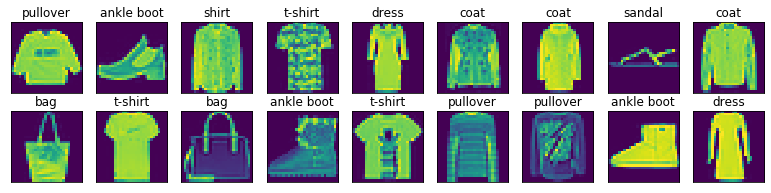

In [7]:
X, y = mnist_train[:18]
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

### 3.5.2 Reading a Minibatch
To make our life easier when reading from the training and test sets, we use a `DataLoader` rather than creating one from scratch, as we did in `Section 3.2`. Recall that at each iteration, a `DataLoader` reads a minibatch of data with size `batch_size` each time.

During training, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. A handy feature of `Gluon`'s `DataLoader` is the ability to use multiple processes to speed up data reading. For instance, we can set aside 4 processes to read the data (via `num_workers`). Because this feature is not currently supported on Windows the following code checks the platform to make sure that we do not saddle our Windows-using friends with error messages later on.

In [8]:
def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

Below, we convert the image data from uint8 to 32-bit floating point numbers using the `ToTensor` class. Additionally, the transformer will divide all numbers by 255 so that all pixels have values between 0 and 1. The `ToTensor` class also moves the image channel from the last dimension to the first dimension to facilitate the convolutional neural network calculations introduced later. Through the `transform_first` function of the dataset, we apply the transformation of `ToTensor` to the first element of each instance (image and label).

In [9]:
batch_size = 256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

Let us look at the time it takes to read the training data.

In [10]:
timer = Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'5.12 sec'

### 3.5.3 Putting All Things Together
Now we define the `load_data_fashion_mnist` function that obtains and reads the `Fashion-MNIST` dataset. It returns the data iterators for both the training set and validation set. In addition, it accepts an optional argument to resize images to another shape.

In [11]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

Below, we verify that image resizing works.

In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, (64, 64))
for X, y in train_iter:
    print(X.shape)
    break

(32, 1, 64, 64)


We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

##### Summary
+ `Fashion-MNIST` is an apparel classification dataset consisting of images representing 10 categories.
+ We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
+ We store the shape of each image with height $h$ width $w$ pixels as $h \times w$ or ($h$, $w$).
+ Data iterators are a key component for efficient performance. Rely on well-implemented iterators that exploit multi-threading to avoid slowing down your training loop.

##### Exercises
1. Does reducing the batch_size (for instance, to 1) affect read performance?
2. For non-Windows users, try modifying num_workers to see how it affects read performance. Plot the performance against the number of works employed.
3. Use the framework's API document website to see which other datasets are available.


## 3.6 Implementation of Softmax Regression from Scratch
Just as we implemented linear regression from scratch, we believe that multiclass logistic (softmax) regression is similarly fundamental and you ought to know the gory details of how to implement it yourself. As with linear regression, after doing things by hand we will breeze through an implementation in `Gluon` for comparison. 

We will work with the `Fashion-MNIST` dataset, just introduced in `Section 3.5`, setting up an iterator with batch size $256$.

In [13]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 3.6.1 Initializing Model Parameters
As in our linear regression example, each example here will be represented by a fixed-length vector. Each example in the raw data is a $28 \times 28$ image. In this section, we will flatten each image, treating them as $784$-long 1D vectors. In the future, we will talk about more sophisticated strategies for exploiting the spatial structure in images, but for now we treat each pixel location as just another feature.

Recall that in `softmax regression`, we have as many outputs as there are categories. Because our dataset has $10$ categories, our network will have an output dimension of $10$. Consequently, our weights will constitute a $784 \times 10$ matrix and the biases will constitute a $1 \times 10$ vector. As with linear regression, we will initialize our weights $W$ with Gaussian noise and our biases to take the initial value $0$.

In [14]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
W.attach_grad()
b.attach_grad()

### 3.6.2 The Softmax
Before implementing the softmax regression model, let us briefly review how operators such as sum work along specific dimensions in an `ndarray`. Given a matrix $X$ we can sum over all elements (default) or only over elements in the same axis, i.e., the column (`axis=0`) or the same row (`axis=1`). Note that if $X$ is an array with shape `(2, 3)` and we sum over the columns (`X.sum(axis=0)`), the result will be a (`1D`) vector with shape `(3,)`. If we want to keep the number of axes in the original array (resulting in a `2D` array with shape `(1, 3)`), rather than collapsing out the dimension that we summed over we can specify `keepdims=True` when invoking sum.

In [15]:
X = np.array([[1, 2, 3], [4, 5, 6]])
X, X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(array([[1., 2., 3.],
        [4., 5., 6.]]),
 array([[5., 7., 9.]]),
 array([[ 6.],
        [15.]]))

We are now ready to implement the softmax function. Recall that softmax consists of two steps: First, we exponentiate each term (using exp). Then, we sum over each row (we have one row per example in the batch) to get the normalization constants for each example. Finally, we divide each row by its normalization constant, ensuring that the result sums to $1$. Before looking at the code, let us recall how this looks expressed as an equation:
$$\mathrm{softmax}(\mathbf{X})_{ij} = \displaystyle\frac{\exp(X_{ij})}{\displaystyle\sum_k \exp(X_{ik})}. $$

The denominator, or normalization constant, is also sometimes called the partition function (and its logarithm is called the log-partition function). The origins of that name are in statistical physics where a related equation models the distribution over an ensemble of particles.

In [16]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp/partition  # The broadcast mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability. Note that while this looks correct mathematically, we were a bit sloppy in our implementation because we failed to take precautions against numerical overflow or underflow due to large (or very small) elements of the matrix, as we did in `Section 18.9`.

In [17]:
X = np.random.normal(size=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(array([[0.22376052, 0.06659239, 0.06583703, 0.29964197, 0.3441681 ],
        [0.63209665, 0.03179282, 0.194987  , 0.09209415, 0.04902935]]),
 array([1.        , 0.99999994]))

### 3.6.3 The Model
Now that we have defined the softmax operation, we can implement the softmax regression model. The below code defines the forward pass through the network. Note that we flatten each original image in the batch into a vector with length `num_inputs` with the reshape function before passing the data through our model.

In [18]:
def net(X):
    return softmax(np.dot(X.reshape(-1, num_inputs), W) + b)

### 3.6.4 The Loss Function
Next, we need to implement the cross-entropy loss function, introduced in `Section 3.4`. This may be the most common loss function in all of deep learning because, at the moment, classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log likelihood of the predicted probability assigned to the true label $-\log P(y \mid x)$. Rather than iterating over the predictions with a Python for loop (which tends to be inefficient), we can use the `pick` function which allows us to easily select the appropriate terms from the matrix of softmax entries. Below, we illustrate the `pick` function on a toy example, with $3$ categories and $2$ examples.

In [19]:
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat, y_hat[[0, 1], [0, 2]]

(array([[0.1, 0.3, 0.6],
        [0.3, 0.2, 0.5]]),
 array([0.1, 0.5]))

Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [20]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

### 3.6.5 Classification Accuracy
Given the predicted probability distribution `y_hat`, we typically choose the class with highest predicted probability whenever we must output a hard prediction. Indeed, many applications require that we make a choice. Gmail must categorize an email into Primary, Social, Updates, or Forums. It might estimate probabilities internally, but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although it can be difficult optimize accuracy directly (it is not differentiable), it is often the performance metric that we care most about, and we will nearly always report it when training classifiers.

To compute accuracy we do the following: First, we execute `y_hat.argmax(axis=1)` to gather the predicted classes (given by the indices for the largest entries in each row). The result has the same shape as the variable `y`. Now we just need to check how frequently the two match. Since the equality operator `==` is datatype-sensitive (e.g., an int and a float32 are never equal), we also need to convert both to the same type (we pick float32). The result is an `ndarray` containing entries of 0 (false) and 1 (true). Taking the mean yields the desired result.

In [21]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis=1).astype('float32') == y.astype(
            'float32')).sum())
    else:
        return float((y_hat.astype('int32') == y.astype('int32')).sum())

We will continue to use the variables `y_hat` and `y` defined in the `pick` function, as the predicted probability distribution and label, respectively. We can see that the first example's prediction category is $2$ (the largest element of the row is $0.6$ with an index of $2$), which is inconsistent with the actual label, $0$. The second example's prediction category is $2$ (the largest element of the row is $0.5$ with an index of $2$), which is consistent with the actual label, $2$. Therefore, the classification accuracy rate for these two examples is $0.5$.

In [22]:
y = np.array([0, 2])
accuracy(y_hat, y) / len(y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the dataset (accessed via `data_iter`).

In [23]:
def evaluate_accuracy(net, data_iter): 
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple numbers.

In [24]:
class Accumulator:  #@save
    """Sum a list of numbers over time."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Because we initialized the `net` model with random weights, the accuracy of this model should be close to random guessing, i.e., $0.1$ for $10$ classes.

In [25]:
evaluate_accuracy(net, test_iter)

0.0811

### 3.6.6 Model Training
The training loop for softmax regression should look strikingly familiar if you read through our implementation of linear regression in `Section 3.2`. Here we refactor the implementation to make it reusable. First, we define a function to train for one data epoch. Note that updater is general function to update the model parameters, which accepts the batch size as an argument. It can be either a wrapper of `d2l.sgd` or a `Gluon` trainer.

In [26]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    metric = Accumulator(3)  # train_loss_sum, train_acc_sum, num_examples
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

Before showing the implementation of the training function, we define a utility class that draws data in animation. Again, it aims to simplify the code in later chapters.

In [27]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear', fmts=None,
                 nrows=1, ncols=1, figsize=(7, 5)):
        """Incrementally plot multiple lines."""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        if not self.fmts:
            self.fmts = ['-'] * n
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The `training` function then runs multiple epochs and visualize the training progress.

In [28]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

Again, we use the minibatch stochastic gradient descent to optimize the loss function of the model. Note that the number of epochs (num_epochs), and learning rate (lr) are both adjustable hyper-parameters. By changing their values, we may be able to increase the classification accuracy of the model. In practice we will want to split our data three ways into training, validation, and test data, using the validation data to choose the best values of our hyperparameters.

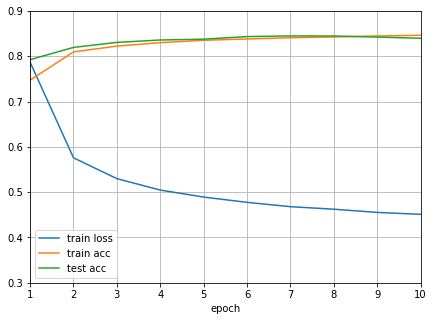

In [29]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 3.6.7 Prediction
Now that training is complete, our model is ready to classify some images. Given a series of images, we will compare their actual labels (first line of text output) and the model predictions (second line of text output).

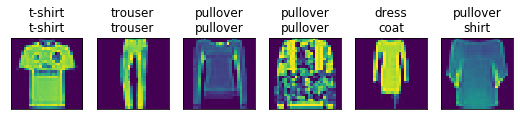

In [30]:
def predict_ch3(net, test_iter, n=6): #@save
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

##### Summary
With softmax regression, we can train models for multi-category classification. The training loop is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

##### Exercises
1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause (hint: try to calculate the size of $\exp(50)$)?
2. The function cross_entropy in this section is implemented according to the definition of the cross-entropy loss function. What could be the problem with this implementation (hint: consider the domain of the logarithm)?
3. What solutions you can think of to fix the two problems above?
4. Is it always a good idea to return the most likely label. E.g., would you do this for medical diagnosis?
5. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?


## 3.7 Concise Implementation of Softmax Regression
Just as `Gluon` made it much easier to implement linear regression in `Section 3.3`, we will find it similarly (or possibly more) convenient for implementing classification models. 

Let us stick with the `Fashion-MNIST` dataset and keep the batch size at $256$ as in the last section.

In [31]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 3.7.1 Initializing Model Parameters
As mentioned in `Section 3.4`, the output layer of softmax regression is a fully-connected layer. Therefore, to implement our model, we just need to add one fully-connected layer with 10 outputs to our `Sequential`. Again, here, the `Sequential` is not really necessary, but we might as well form the habit since it will be ubiquitous when implementing deep models. Again, we initialize the weights at random with zero mean and standard deviation $0.01$.

In [32]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

### 3.7.2 The Softmax
In the previous example, we calculated our model's output and then ran this output through the cross-entropy loss. Mathematically, that is a perfectly reasonable thing to do. However, from a computational perspective, exponentiation can be a source of numerical stability issues (as discussed in `Section 18.9`). Recall that the softmax function calculates $\hat y_j = \displaystyle\frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}$, where $\hat y_j$ is the $j^\mathrm{th}$ element of `y_hat` and $z_j$ is the $j^\mathrm{th}$ element of the input `y_linear` variable, as computed by the softmax.

If some of the $z_i$ are very large (i.e., very positive), then $e^{z_i}$ might be larger than the largest number we can have for certain types of float (i.e., overflow). This would make the denominator (and/or numerator) inf and we wind up encountering either $0$, inf, or nan for $\hat y_j$. In these situations we do not get a well-defined return value for `cross_entropy`. One trick to get around this is to first subtract $\text{max}(z_i)$ from all $z_i$ before proceeding with the softmax calculation. You can verify that this shifting of each $z_i$ by constant factor does not change the return value of softmax.

After the subtraction and normalization step, it might be that possible that some $z_j$ have large negative values and thus that the corresponding $e^{z_j}$ will take values close to zero. These might be rounded to zero due to finite precision (i.e underflow), making $\hat y_j$ zero and giving us -inf for $\text{log}(\hat y_j)$. A few steps down the road in backpropagation, we might find ourselves faced with a screenful of the dreaded not-a-number (nan) results.

Fortunately, we are saved by the fact that even though we are computing exponential functions, we ultimately intend to take their log (when calculating the cross-entropy loss). By combining these two operators (softmax and cross_entropy) together, we can escape the numerical stability issues that might otherwise plague us during backpropagation. As shown in the equation below, we avoided calculating $e^{z_j}$ and can instead $z_j$ directly due to the canceling in $\log(\exp(\cdot))$.
$$ \begin{aligned} \log{(\hat y_j)} & = \log\left( \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}\right) \\ & = \log{(e^{z_j})}-\text{log}{\left( \sum_{i=1}^{n} e^{z_i} \right)} \\ & = z_j -\log{\left( \sum_{i=1}^{n} e^{z_i} \right)}. \end{aligned} $$

We will want to keep the conventional softmax function handy in case we ever want to evaluate the probabilities output by our model. But instead of passing softmax probabilities into our new loss function, we will just pass the logits and compute the softmax and its log all at once inside the `softmax_cross_entropy` loss function, which does smart things like the log-sum-exp trick (see on Wikipedia).

In [33]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

### 3.7.3 Optimization Algorithm
Here, we use minibatch stochastic gradient descent with a learning rate of $0.1$ as the optimization algorithm. Note that this is the same as we applied in the linear regression example and it illustrates the general applicability of the optimizers.

In [34]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

### 3.7.4 Training
Next we call the training function defined in the last section to train a model.

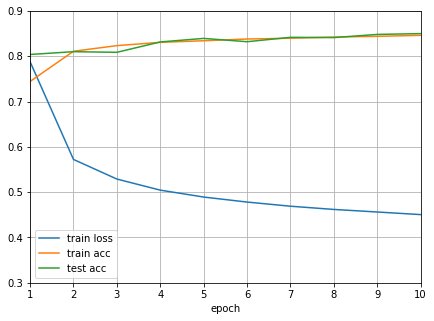

In [35]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

As before, this algorithm converges to a solution that achieves an accuracy of $83.7\%$, albeit this time with fewer lines of code than before. Note that in many cases, `Gluon` takes additional precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.